In [32]:
from pathlib import Path
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa

import sklearn


In [29]:
def prepare_data():
    full_data = pd.read_csv(Path().resolve().joinpath("dataset/full_data.csv"))
    full_data[["hypertension", "heart_disease", "ever_married", "stroke"]] = full_data[
        ["hypertension", "heart_disease", "ever_married", "stroke"]
    ].replace(
        [1, 0, "Unknown"], ["Yes", "No", ""]
    )  # prevent interfence with StringLookup layer

    full_data = full_data.drop_duplicates().dropna()
    data_shuffled = full_data.sample(frac=1, random_state=0)

    # create test dataset of 50 positive / 50 negative
    pos_rows = data_shuffled.loc[(full_data["stroke"] == "Yes")][:25]
    neg_rows = data_shuffled.loc[(full_data["stroke"] == "No")][:25]

    test_data = pd.concat([pos_rows, neg_rows])
    train_data = (
        pd.merge(full_data, test_data, how="outer", indicator=True)
        .query('_merge=="left_only"')
        .drop("_merge", axis=1)
    )  # exclude test data from train dataset

    # balance training dataset

    # train_pos = train_data[train_data["stroke"] == "Yes"]
    # train_neg = train_data[train_data["stroke"] == "No"][:len(train_pos)] # .50 split, paper reccomends 65/15/20%
    # train_data = pd.concat([train_pos, train_neg])
    # train_data = train_data.sample(0.1)

    test_data.to_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), index=False, header=False
    )
    train_data.to_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), index=False, header=False
    )

    return test_data, train_data


In [49]:
def generate_test(shuffle_data_df: DataFrame):
    """take 500 rows with"""
    test_set = shuffle_data_df[4500:]

    return test_set


def generate_train_valid(shuffled_data_df):
    return shuffled_data_df[:4500]


def read_and_shuffle_data():
    full_data = pd.read_csv(Path().resolve().joinpath("dataset/full_data.csv"))
    shuffled = full_data.sample(frac=1, random_state=0)

    return shuffled


def prepare_data_tvt():
    full_data_shuffled = read_and_shuffle_data()

    full_data_shuffled[
        ["hypertension", "heart_disease", "ever_married", "smoking_status", "stroke"]
    ] = (
        full_data_shuffled[
            [
                "hypertension",
                "heart_disease",
                "ever_married",
                "smoking_status",
                "stroke",
            ]
        ]
        .replace([1, 0, "Unknown"], ["Yes", "No", ""])
    )  # prevent interfence with StringLookup layer

    full_data_shuffled = full_data_shuffled.drop_duplicates().dropna()

    test_df = generate_test(full_data_shuffled)
    train_df = generate_train_valid(full_data_shuffled)

    test_df.to_csv(Path().resolve().joinpath("dataset/test_data.csv"))
    train_df.to_csv(Path().resolve().joinpath("dataset/train_data.csv"))

    return test_df, train_df


train_data = DataFrame()
test_data = DataFrame()

try:
    train_data = pd.read_csv(Path().resolve().joinpath("dataset/train_data.csv"))
    test_data = pd.read_csv(Path().resolve().joinpath("dataset/test_data.csv"))

except:
    test_data, train_data = prepare_data_tvt()


print(
    f"Using {len(train_data)} samples for training and {len(test_data)} for validation"
)


Using 4500 samples for training and 481 for validation


In [4]:
# prepare data
CSV_HEADER = [
    "gender",
    "age",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "avg_glucose_level",
    "bmi",
    "smoking_status",
    "stroke",
]

train_data_path = Path().resolve().joinpath("dataset/train_data.csv")
test_data_path = Path().resolve().joinpath("dataset/test_data.csv")

train_data_file = str(train_data_path.absolute())
test_data_file = str(test_data_path.absolute())

NUMERIC_FEATURE_NAMES = [
    "age",
    "avg_glucose_level",
    "bmi",
]  # list of numeric feature names

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "gender": sorted(list(train_data["gender"].unique())),
    "hypertension": sorted(list(train_data["hypertension"].unique())),
    "heart_disease": sorted(list(train_data["heart_disease"].unique())),
    "ever_married": sorted(list(train_data["ever_married"].unique())),
    "work_type": sorted(list(train_data["work_type"].unique())),
    "Residence_type": sorted(list(train_data["Residence_type"].unique())),
    "smoking_status": sorted(list(train_data["smoking_status"].unique())),
}

# metadata

# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# The name of the target feature.
TARGET_FEATURE_NAME = "stroke"
# A list of the labels of the target features.
TARGET_LABELS = ["Yes", "No"]


In [5]:
# model hyperparameters

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 100

NUM_TRANSFORMER_BLOCKS = 6  # Number of transformer blocks.
NUM_HEADS = 8  # Number of attention heads.
EMBEDDING_DIMS = 32  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    4,
    2,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.


In [6]:
# data proccessing pipeline

target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    return features, target_index


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    """dataset from, csv"""
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2022-08-25 21:39:48.063786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 21:39:48.064943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 21:39:48.066182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 21:39:48.066537: W tensorflow/stream_executor/platform/default/dso_loader.cc

In [7]:
def create_model_inputs():
    """Create model inputs"""
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


def encode_inputs(inputs, embedding_dims):
    """Encode features"""

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    print(encoded_categorical_feature_list)

    return encoded_categorical_feature_list, numerical_feature_list


In [8]:
# training and evaluation


def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    batch_size,
):
    """Implement a training and evaluation procedure"""

    # optimizer = tfa.optimizers.AdamW(
    #    learning_rate=learning_rate, weight_decay=WEIGHT_DECAY
    # )
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history


In [9]:
# MLP block
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    """MLP block"""

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)


def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    """MLP model without transformer layers"""

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.relu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


[<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_1')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_2')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_3')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_4')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_5')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_6')>]
Total model weights: 830551


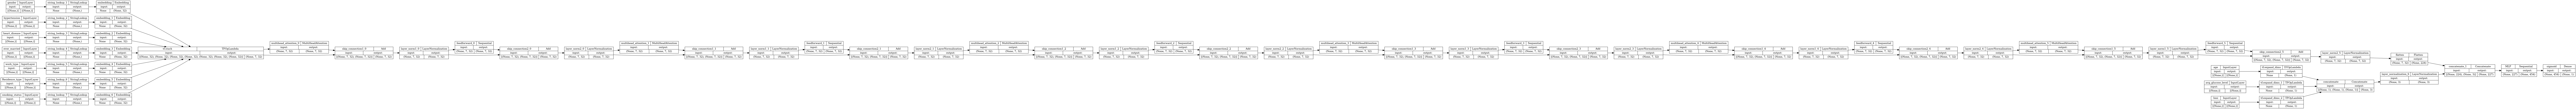

In [10]:
# tabtransformer block


def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
    # use_column_embedding=True
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


[<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_14')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_15')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_16')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_17')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_18')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_19')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'embedding_20')>]
Total model weights: 726069


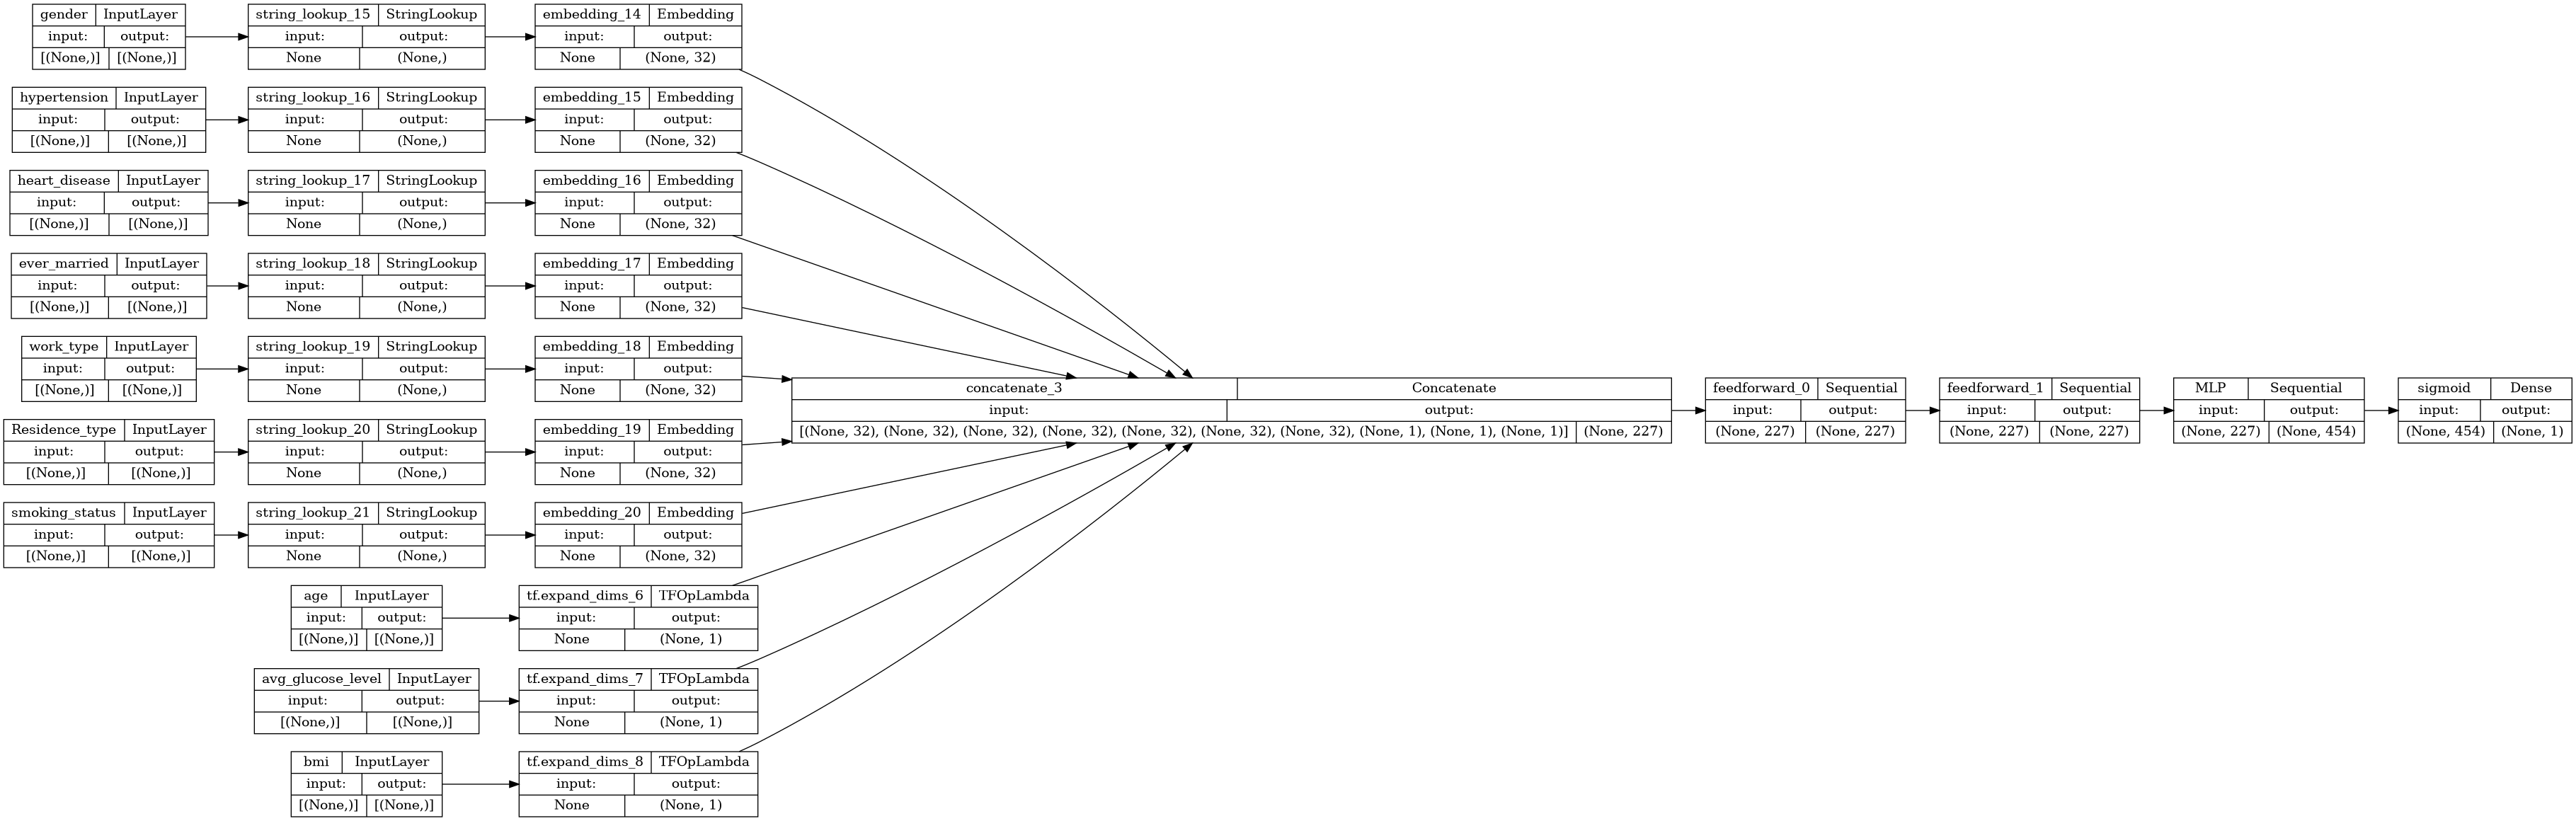

In [50]:
# define a baseline model without transformer layer

baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")


In [51]:
# run and evaluate baseline model
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


ValueError: Problem inferring types: CSV row 1 has 12 number of fields. Expected: 11.

In [20]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
14/14 [==============================] - 12s 149ms/step - loss: 1.1255 - accuracy: 0.6682 - val_loss: 1.0017 - val_accuracy: 0.6600
Epoch 2/100
14/14 [==============================] - 1s 44ms/step - loss: 0.5463 - accuracy: 0.7534 - val_loss: 0.8127 - val_accuracy: 0.5400
Epoch 3/100
14/14 [==============================] - 1s 42ms/step - loss: 0.5890 - accuracy: 0.7287 - val_loss: 0.9478 - val_accuracy: 0.5800
Epoch 4/100
14/14 [==============================] - 1s 41ms/step - loss: 0.5398 - accuracy: 0.7354 - val_loss: 0.9445 - val_accuracy: 0.5400
Epoch 5/100
14/14 [==============================] - 1s 43ms/step - loss: 0.5145 - accuracy: 0.7332 - val_loss: 0.8099 - val_accuracy: 0.5600
Epoch 6/100
14/14 [==============================] - 1s 42ms/step - loss: 0.4658 - accuracy: 0.7691 - val_loss: 1.0293 - val_accuracy: 0.5800
Epoch 7/100
14/14 [==============================] - 1s 41ms/step - loss: 0.4413 - accuracy: 0.7713 - val_loss: 0.7008